## <img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Dimensionality Reduction SWDB 2022 </h1> 
<h3 align="center">Monday, August 29, 2022</h3> 

In [1]:
# Import the packages we will use.
import os
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
%matplotlib inline


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
In this tutorial, we look at dimensionality reduction. Dimensionality reduction is the process of taking high dimesnional data (such as a population of recorded neurons) and trasforming it it into a space that is lower dimesional and (hopefully) easier to understand. We will go over one of the most common and important forms of dimensionality reduction; <b>Principal Components Analysis</b> (PCA).
</p>
    
<p> PCA works by identifying the dimensions of a dataset that contain the most variance (more on this to come!). Because this dimensionality reduction is based on the inherent structure of the data, it is one of the most common forms of <b>unsupervised learning</b>.  In contrast to supervised learning, unsupervised learning operates on a set of data points without labels or ids.  Instead of trying to find a transformation between the data and labels attached to the data, we seek to find a transformation that discovers structure in the data.
</p>
    


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FBE9E7; ">
<p>
A mathematical definition of PCA follows; The explaination above can be a little mistifying if you haven't had enough coffee and/or if it has been a minute since your last linear algebra class. We will spend more time on the pictographic version below, but there is here for a reference for those who need it!
</p>     

<p>
Lets assume the data $\vec{x}_i$ exists in $N$ dimensions.  Given an integer $n < N$, PCA attemps to find a linear subspace of dimension $n$ that minimizes the variance of the data outside of that subspace.  Put another way, PCA defines a subspace of dimension $n < N$ such that, when the data is approximated by projecting onto that subspace, the reconstruction error is minimized. In short, PCA finds the dimensions along which the data is most spread out. These dimensions are not necessarily those present within the data, but more often are linear combinations of them.
</p>
    
<p>
Let us denote the subspace with the orthogonal matrix ${\bf W}$, of dimensions $(n, N)$.  The data can be represented with the matrix ${\bf X}$, of dimensions $(T, N)$, where $T$ is the number of samples.  Let the coordinates of the data in the subspace be labelled ${\bf Z}$, which is of dimensions $(T, n)$.  The cost function for PCA is then
</p>
<p>
$E = \frac{1}{2}  \left | {\bf X} - {\bf Z} \cdot {\bf W} \right |^2$
</p>
<p>
    Note that we have to optimize over <i>both</i> ${\bf Z}$ and ${\bf W}$, subject to the constraint that ${\bf W}$ is orthogonal.
</p>
<p>
We can equivalently define PCA by specifying the principal components as the eigenvectors of the covariance matrix with the $n$ largest eigenvalues.  Intuitively one can see that this choice will produce the smallest amount of variability away from the subspace, as the eigenvectors themselves indicate the direction of maximum variability, and thus will solve the problem as we originally defined it.  This allows us to compute the PCAs very simply with diagonalization or singular value decomposition.
</p>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
To understand PCA intuitivly, consider this whale shark (Borrowed shamelessly from #AllisonHorst on twitter):
</p>

<img src="../resources/PCAWhale1.png" width = 500>  
    
<p>
Now, imagine that the shark needs to eat this school of krill:
</p>

<img src="../resources/PCAWhale2.png" width = 500>  
    
<p>
Principal components analysis provides a an algorithm that the shark can use to maximize how many krill will end up in its mouth. 
</p>
    
   
<p> 
To see how this works, lets start by imaging that the shark has a couple of footballs (this is, obviously, a super realistic example). To find the widest dimension of krill the shark will need to engulf, they can try to hold a football such that it entirly covers the krill population. The widest dimension will be the one in which the smallest football can cover all of the krill. Another way of saying this is that the football needs to be positioned to minimze the travel of any given krill trying to leave it.
</p>
    
<img src="../resources/KrillPlot1.png"  width = 500>  

<img src="../resources/KrillPlot2.png"  width = 500>  

    
<p>
Mathematically, the vector of the long axis of this football is known as the first eigenvector of the covariance matrix of the data, that is, the vector that describes the most variance in our data/krill. In principal components analysis, this is called the first principal component. The amount the shark needs to resize the football is proportional to a quanitity know as the first eigenvalue. 
    
</p>
    
<p>  
Now that the whale-shark has established this first vector, the next step is to establish a second. This is done by compressing all of the krill along the vector established by the first football, then fitting a second football to the remaining data.
</p>
    
<img src="../resources/KrillPlot4.png"  width = 500>  
        
<p>
We call the vector of this second football the second eigenvector of the covariance matrix, that is, the second principal component. The amount that this football is resized scales with the second eigenvalue. 
</p>
    
<p>
Importantly, this algorithm enforces that that the direction of each football be orthogonal to one another. If we had additional dimensions, it would be enforced for the relationships between all of the principle components. If you hate this assumtion, there is a class of algorithms you can look into called 'independant components analysis,' which is similar to PCA but does require that your footballs be orthogonal to each other.
</p>

<p>
In the case of our whale shark, the principle components are directly interpretable. The first principle component tells the shark how to rotate its mouth to fit around the school of krill, and the projections of the krill onto the second principle component tell the shark how far it needs to open its mouth. Another way of saying this is that we have found a linear transform from shark-space to krill space. 
</p>


Let's start by actually implementing this algorithm on some toy data. You may notice a striking similarity to the krill above.

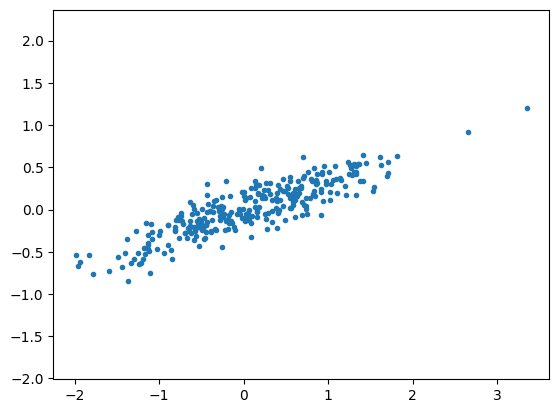

In [2]:
# generate some random 2 dimensional data
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 300))).T

#plot random data
plt.plot(X[:, 0], X[:, 1], '.');
plt.ylim(-3,3);
plt.xlim(-3,3);
plt.axis('equal');
# Note that this dataset has a mean of 0 in both dimensions. This will be important later. 

In [3]:
# X now has 300 data points, each with 2 dimensions
X.shape

(300, 2)

In [5]:
# Construct Covariance Matrix. 
# Because X has 2 dimensions, it will be a square 2x2 matrix
cov = (1.0/X.shape[0])*np.dot(X.T, X)
# Alternativly: A = np.cov(X.T)

In [6]:
# Next, do the eigenvalue decomposition of this matrix
evalues, evectors = np.linalg.eig(cov)
print('evalues: ' + str(evalues))
print('evectors: ' + str(evectors))

evalues: [0.7816288  0.02002772]
evectors: [[ 0.94645942 -0.32282282]
 [ 0.32282282  0.94645942]]


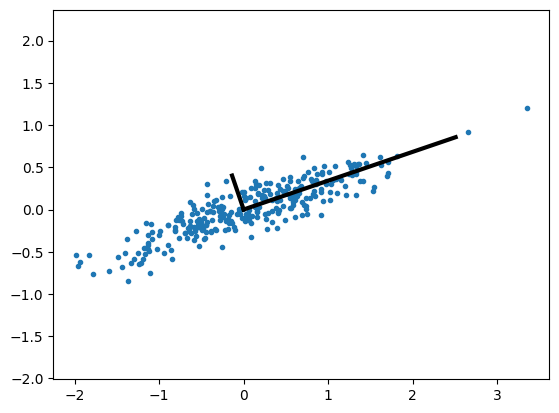

In [7]:
# Now Lets look at how these eigenvectors fall relative to our data
#fig, ax = plt.subplots(figsize=(5,5))

plt.plot(X[:, 0], X[:, 1], '.')
for value, vector in zip(evalues, evectors.T):
    plt.plot([0, 3.*np.sqrt(value)*vector[0]], [0, 3.*np.sqrt(value)*vector[1]], '-k', lw=3);

plt.ylim(-3,3);
plt.xlim(-3,3);
plt.axis('equal');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
In this case, our PCA is an orthogonal coordinate system transformation that prioritizes maximum variance. However, one can already see that the majority of the variance in our data is explained by a single principal component!

Project the values onto the each of the principal components

In [8]:
# Project data onto first eigenvector
X_proj_1 = np.dot(X, evectors.T[0])

In [9]:
# We have one projection value for each data point
X_proj_1.shape

(300,)

Text(0.5, 0, 'First principal component')

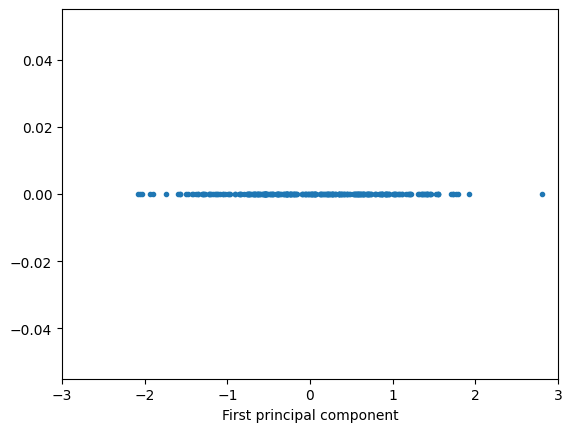

In [10]:
# Visualize!
plt.plot(X_proj_1, np.zeros(X_proj_1.shape), '.');
plt.xlim(-3,3);
plt.xlabel("First principal component")

Text(0.5, 0, 'Second principal component')

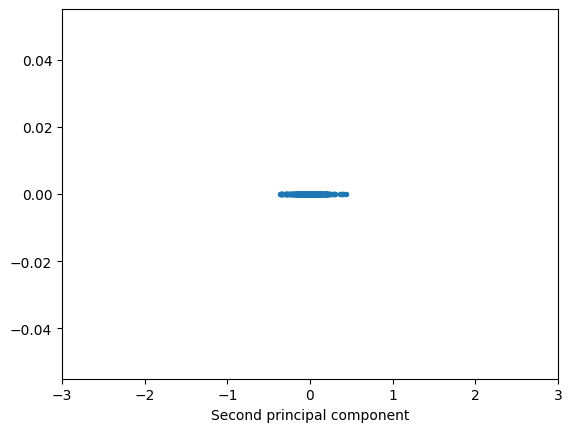

In [11]:
# Project data onto the second eigenvector
X_proj_2 = np.dot(X, evectors.T[1])

# Visualize!
plt.plot(X_proj_2, np.zeros(X_proj_2.shape), '.');
plt.xlim(-3,3);
plt.xlabel("Second principal component")

At the end of the day, all our principal components transform has done is rotate the data into a new coordinate space.


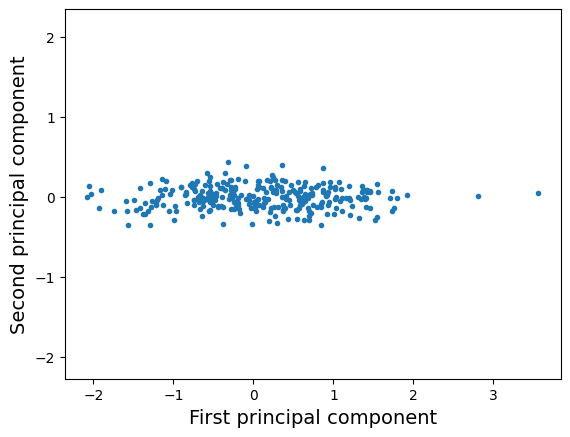

In [12]:
plt.plot(X_proj_1, X_proj_2, '.');
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)

plt.axis('equal');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

### Now let's use sklearn.
    


 <p>

<code>scikit-learn</code> provides a more streamlined interface for performing a Principal Components Analysis. Here we will use it first on the same toy data as above, and then on some data from the Behavior recordings. The interface will be the same for other algorithms in <code>scikit-learn</code>, such as those you saw in the regression tutorial
</div>


In [13]:
from sklearn.decomposition import PCA

In [14]:
# First, declare a PCA object that can be used for computing PCAs
# If you don't specify the number of components, the 'default' is as many dimensions as your data has
# This won't change the output of the algorithm, just how many PCs sklearn returns
pca = PCA(n_components=2) 

In [15]:
# Next, do a dimensionality reduction on X
pca.fit(X);

In [16]:
# The PCA object automatically does the same computation we did above, though it uses some different nomenclature
# the Eigenvalues are stored as 'explained variance_'
pca.explained_variance_

array([0.77935137, 0.02004522])

In [17]:
# and the eigenvectors are stored as "components"
pca.components_
# Compare this to the values above... are they the same? (Hint: They should be)

array([[ 0.94625072,  0.32343403],
       [-0.32343403,  0.94625072]])

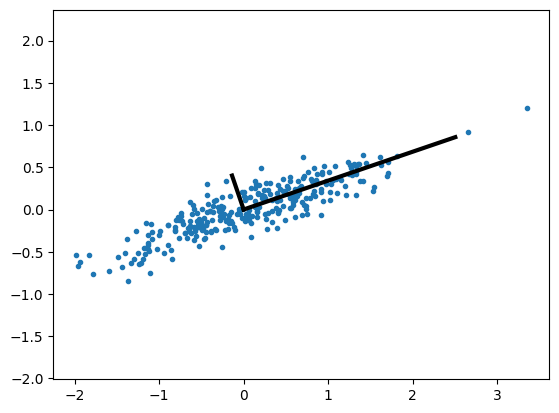

In [18]:
# We can plot these data to verify that everything matches up.
ax = plt.subplot(1,1,1)
ax.plot(X[:, 0], X[:, 1], '.')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    ax.plot([0, v[0]], [0, v[1]], '-k', lw=3);

ax.set_ylim(-3,3);
ax.set_xlim(-3,3);
ax.axis('equal');

### Now let's look at the data projected onto the transforms

In [19]:
X_project = pca.transform(X)

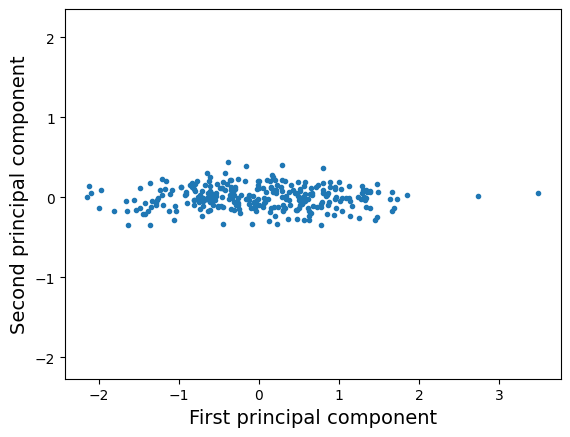

In [20]:
# This, too, should look a lot like the plot above.
plt.plot(X_project[:,0], X_project[:,1], '.');
plt.xlabel("First principal component", fontsize=14);
plt.ylabel("Second principal component", fontsize=14);
plt.axis('equal');

Since the first principal component explains most of the variance, we can also project our two-dimensional data into a one-dimensional space (making use of the dimensionality-reduction that can be accomplished with PCA!) Note the similarity between this projection and the full data. This will be similar to what happens to high-dimensional data that is reduced to two dimensions for the examples below!

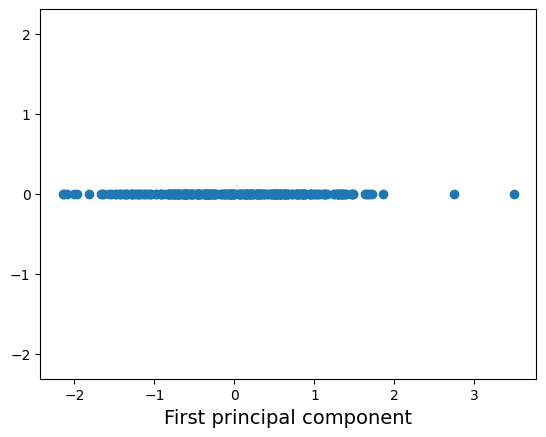

In [21]:
# Plotting only the first principal component
plt.plot(X_project[:,0], np.zeros(len(X_project[:,0])), 'o');
plt.xlabel("First principal component", fontsize=14);
plt.axis('equal');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

## Let's try this with some real data from the Visual Behavior dataset!!!

In [22]:
import allensdk
from allensdk.brain_observatory.\
    behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import os
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

#data_root =  '../Data'
# get the cache location
cache_dir = os.path.join(data_root, data_dirname)

#cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=cache_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [23]:
# We need to find which units have the sessions we are interested in, so we will need the units and sessions tables.
units_table = cache.get_unit_table()
ecephys_sessions_table = cache.get_ecephys_session_table()

In [24]:
# First, we want to find a "Good" Session to look at;
# For now, we are going to grab the one with the most MRN units.
unit_by_session = units_table.join(ecephys_sessions_table,on = 'ecephys_session_id')
unit_in = unit_by_session[(unit_by_session['structure_acronym']=='MRN') & (unit_by_session['experience_level']=='Familiar')]
unit_count = unit_in.groupby(["ecephys_session_id"]).count()
familiar_session_with_most_in_units = unit_count.index[np.argmax(unit_count['ecephys_probe_id'])]

In [30]:
# Actually imort the data
session = cache.get_ecephys_session(ecephys_session_id=familiar_session_with_most_in_units)

/Users/christinejunhuiliu/opt/anaconda3/envs/swdb2022/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [31]:
# Get unit information
session_units = session.get_units()
# Channel information
session_channels = session.get_channels()
# And accosiate each unit with the channel on which it was found with the largest amplitude
units_by_channels= session_units.join(session_channels,on = 'peak_channel_id')

# Filter for units in primary visual cortex
this_units = units_by_channels[(units_by_channels.structure_acronym == 'MRN')\
                               &(units_by_channels['isi_violations']<.5)\
                               &(units_by_channels['amplitude_cutoff']<0.1)\
                               &(units_by_channels['presence_ratio']>0.95)]
# Get the spiketimes from these units as a dictionary
this_spiketimes = dict(zip(this_units.index, [session.spike_times[ii] for ii in this_units.index]))

Recall that PCA operates on a (𝑇,𝑛) matrix X, where T is the number of timepoints and n is the number of dimensions.

For a spiketrain, we typically consider each "dimension" to be the a single unit, and each sample to be the number of times that unit fires (i.e. its firing rate) within a specified time bin. 

The timescale you choose here matters; it will govern the timescale of the dynamics you are able to see. To start, lets choose a timescale of 50 ms bins (.05 seconds)

In [27]:
# To start, lets use 50 ms bins.
dt = .05

# Take the time when the animal is activly behaving
active_stims = session.stimulus_presentations[session.stimulus_presentations.stimulus_block==0 ]

# Define time bins that span this period with intrerval dt
session_start_time = np.min(active_stims.start_time)
session_end_time = np.max(active_stims.start_time) 
tme = np.arange(session_start_time,session_end_time,dt)

# Bin data from each unit to build X
X = np.zeros((len(this_units),len(tme)-1))
for ii,un in enumerate(this_units.index):
    my_spiketimes = this_spiketimes[un]
    X[ii,:] = np.histogram(my_spiketimes,tme)[0]
    

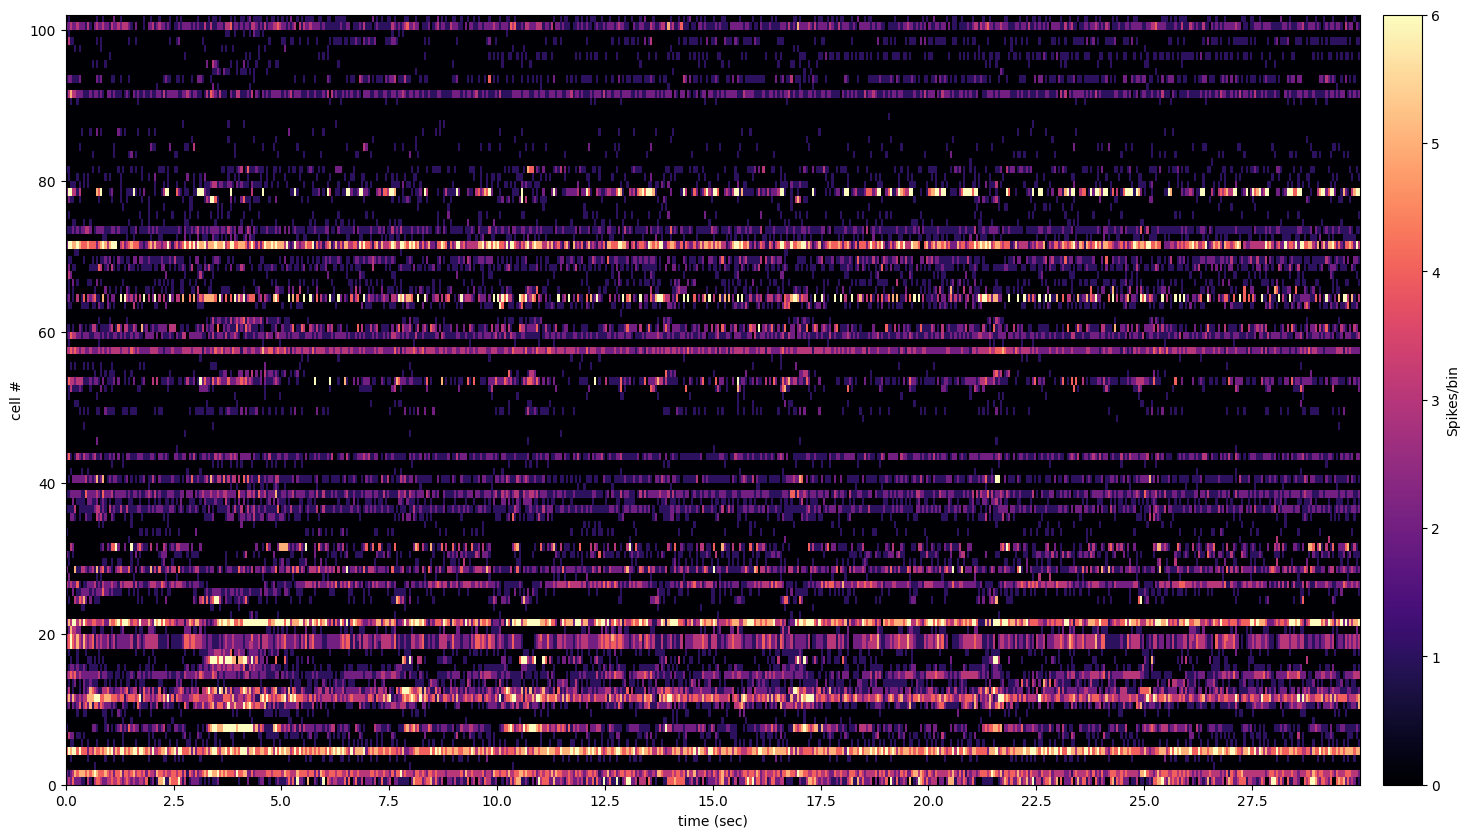

In [28]:
# Plot a heatmap of the activitiy of all the cells
fig, ax = plt.subplots(figsize = (20,10))

rng = int(30/dt)
cax = plt.pcolormesh(X[:,:rng],
                    vmin = 0, vmax = np.percentile(X[:,:rng], 99),
                    cmap = 'magma')
ax.set_xticks(np.arange(0,rng,50))
ax.set_xticklabels(np.arange(0,dt*rng,dt*50))

# label axes 
ax.set_ylabel('cell #')
ax.set_xlabel('time (sec)')

# creating a color bar
cb = plt.colorbar(cax, pad=0.015, label='Spikes/bin')

Before running PCA, the data in each dimension should have a mean zero. Otherwise, large values offset from zero can and will dominate our eigenvalue decomposition, making any results tricky to interpret! 

In practice, sklearn automatically does this (you can turn it off for very special cases), but we have externalized it here to help with understanding how PCA works.

The data should be in the form of (N,T) where N is dimension (in this case the number of neurons) and T is the number of samples (i.e. the number of time bins. 

In [29]:
# Subtract the mean of each dimension
X = (X.T-np.mean(X.T,axis = 0))
print(X.shape) # (N,D)
np.mean(X,axis =0)#<--realy small numbers.


(72207, 102)


array([-1.33828870e-17,  2.83402313e-17,  1.76339217e-16,  3.53268855e-17,
       -5.66804625e-17,  7.08505782e-18,  2.59785453e-17, -3.46380604e-17,
        8.81696084e-17, -3.78853786e-18, -2.04679448e-17, -1.73190302e-16,
       -1.85785961e-16,  5.90421485e-17,  5.03826334e-17,  9.84035808e-17,
        1.58232958e-16,  2.04679448e-17,  6.29782917e-17, -1.00765267e-16,
        6.53399776e-17,  1.25956583e-17, -4.72337188e-18, -6.88825065e-18,
       -4.26087505e-17, -5.03826334e-17,  1.59807415e-16, -4.72337188e-18,
        0.00000000e+00,  7.08505782e-18, -5.35315479e-17, -1.32254413e-16,
        1.96807162e-18,  1.69254159e-17, -1.88934875e-17,  2.67657740e-17,
        5.51060052e-17,  2.12551734e-17, -4.95954047e-17, -1.96807162e-19,
       -2.20424021e-17, -9.84035808e-18,  7.87228646e-19, -5.03826334e-17,
       -3.54252891e-18,  5.95341664e-18, -9.76163521e-17, -1.18084297e-18,
        0.00000000e+00, -1.25956583e-17, -3.82543920e-18, -1.25956583e-17,
       -2.20424021e-17,  

#### Exersize (1): Now, fit a pca on X for our behavior data. For now, don't limit the number of principle components returned.

HINT: The code to do this is above.

In addition to provideing the eigenvalue for your data as `explained_variance_`, the sklearn PCA object will compute the fraction of variance explained by each eigenvalue as `explained_variance_ratio_`. This is just the each eigenvalue divided by the sum of all eigenvalues to make it more interpretable.

#### Exersize (2): Plot the explained variance ratio for each princple component. It is easier to see if you plot them as dots. (marker = '.')

#### Exersize (3): Finally, transform the data X into princple components space.

So that your code will work with the rest of this tutorial, save the transformed results as "proj." 

Try plotting the first 2 dimensions of "proj." What does the structure of the data look like?

In [33]:
proj = pca.transform(x)

NameError: name 'x' is not defined

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

## Next, Lets take a closer look at what the PCs tell us about our population of neurons

In [32]:
# Because we binned time above, we also need to bin some of our behavioral features
# For continuous data, we can interpolate in one dimension
from scipy.interpolate import interp1d
running_speed= interp1d(session.running_speed.timestamps,session.running_speed.speed)(tme[:-1])
# For discrete data, we can use the same np.histogram command we used above
licks  = np.histogram(session.licks,tme)[0]>0


In [ ]:
# Plot some behavior relative to the 
licks  = np.histogram(session.licks,tme)[0]>0
fig,ax = plt.subplots(nrows = 2,ncols = 1,figsize = (7,10))
ax[0].scatter(proj[licks==0,0],proj[licks==0,1],label = 'no lick')
ax[0].scatter(proj[licks==1,0],proj[licks==1,1],label = 'lick')
ax[0].legend()
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].hist(proj[licks==0,0],density=True,label = 'no licks',alpha = .7)
ax[1].hist(proj[licks==1,0],density=True,label = 'licks',alpha = .7)

ax[1].set_xlabel('PC1')
ax[1].set_ylabel('Fraction of bins')
ax[1].legend();

In [ ]:
# Running speed
running_speed= interp1d(session.running_speed.timestamps,session.running_speed.speed)(tme[:-1])
fig,ax = plt.subplots(figsize = (7,5))
sct = ax.scatter(proj[:,0],proj[:,1],c = running_speed,marker= '.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2') 
#cbar = sct.colorbar()
#cbar.ax.set_ylabel('Running speed')
cb = plt.colorbar(sct, pad=0.015, label='Running Speed')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
Lets take a moment to think about what we have done here. PCA looks for the dimension that describes the most variance in our data - in this case the activity of some neurons. We never explicity gave our algorithm any information about licking or running!
    </p>
    <p>
This is a demonstration about why PCA and algorithms like it are refered to as unsupervised learning. They do not consider outside labeling or annotation, but instead rely solely on the inherent structure in the data. This can (sometimes) facilitate understand of what is going on in a dataset.
    </p>
    <p>

There are many other unsupervised learning methods.  They are helpful when trying to either reduce the complexity of the dataset in order to facilitate another computation (such as regression or classification) or for exploratory data analysis in which one is trying to discover structure that may be obscured by noise or not immediately clear due to high dimensionality.
    </p>
    <p>
One of the <b> very </b> nice things about the sklearn interface is that it makes it easy to try different unsupervised models. Each model is built around a standard interface with a standard set of commands (e.g. `.fit`, `.transform`, etc.). A list of other unsupervised models implemented in sklean is avalible here:      https://scikit-learn.org/stable/supervised_learning.html


Finally, lets look at the make up of our principal components. Do they typically describe the activity of one or many cells?

In [ ]:
#First principal compnent. 
plt.plot(pca.components_[0],label = 'PC1')
plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Projection strength")

In [ ]:
#First principal compnent. 
plt.plot(pca.components_[0],label = 'PC1')
#Subsequent components. 
plt.plot(pca.components_[1],label = 'PC2')
plt.plot(pca.components_[2],label = 'PC3')
plt.plot(pca.components_[3],label = 'PC4')

plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Projection strength");
plt.legend()